## To run the pipeline:
##### in general: test_mode is a boolean argument, that speeds up all processes by using pre-existing data if found.
##### for a real analysis or to overwrite pre-existing files, you should set test_mode to False

In [1]:
from core.meta import meta_interface

##### overwrite: bool whether to overwrite the meta.yaml at the given project_name or if existing appending the project_name by _01

In [2]:
d = meta_interface(
    project_config_filepath="test_data/project_config.yaml",
    project_name="test_data",
    overwrite=True,
)

In [3]:
d.add_recording_config(
    "test_data/Server_structure/Calibrations/220922/recording_config_220922.yaml"
)

In [4]:
d.initialize_meta_config()

Found 1 recordings at recording day 220922!


#### creates undistorted images per cam and reads metadata
##### test_mode = True doesnt save the undistorted images

In [5]:
d.create_recordings(test_mode=True)

#### runs synchronisation and DLC analysis
##### test_mode=True doesn't overwrite already existing synchronized/analysed files
##### synchronize_only=True doesn't DLC analyse files
##### verbose=True prints the duration of one recording analysis

In [6]:
d.synchronize_recordings(verbose=True, test_mode=True)

Frames after synchronization: 74124
Frames after synchronization: 74124
Frames after synchronization: 74124
Frames after synchronization: 74124
Frames after synchronization: 74124
Frames after synchronization: 74123
Frames after synchronization: 74118
The analysis of this recording 206_F2-63_220922_OTE took 0.5598959922790527.



#### creates undistorted images per cam and reads metadata
##### test_mode = True doesnt save the undistorted images

In [7]:
d.create_calibrations(
    ground_truth_config_filepath="test_data/ground_truth_config.yaml", test_mode=True
)

#### runs synchronisation
##### test_mode=True doesn't overwrite already existing synchronized videos

In [8]:
d.synchronize_calibrations(test_mode=True)

Frames after synchronization: 18447
Frames after synchronization: 18445
Frames after synchronization: 18445
Frames after synchronization: 18445
Frames after synchronization: 18445
Frames after synchronization: 18445
Frames after synchronization: 18445


#### Anipose calibration
##### calibrate_optimal = True uses calibration_validation for repeated calibrations
##### verbose > 1 shows aniposelib output. verbose > 0 shows Calibration_validation output. verbose = 0 doesnt show any output

In [9]:
d.calibrate(verbose=1, calibrate_optimal=False, test_mode=True)

100%|█████████████████████| 2371776/2371776 [12:07<00:00, 3258.74it/s]


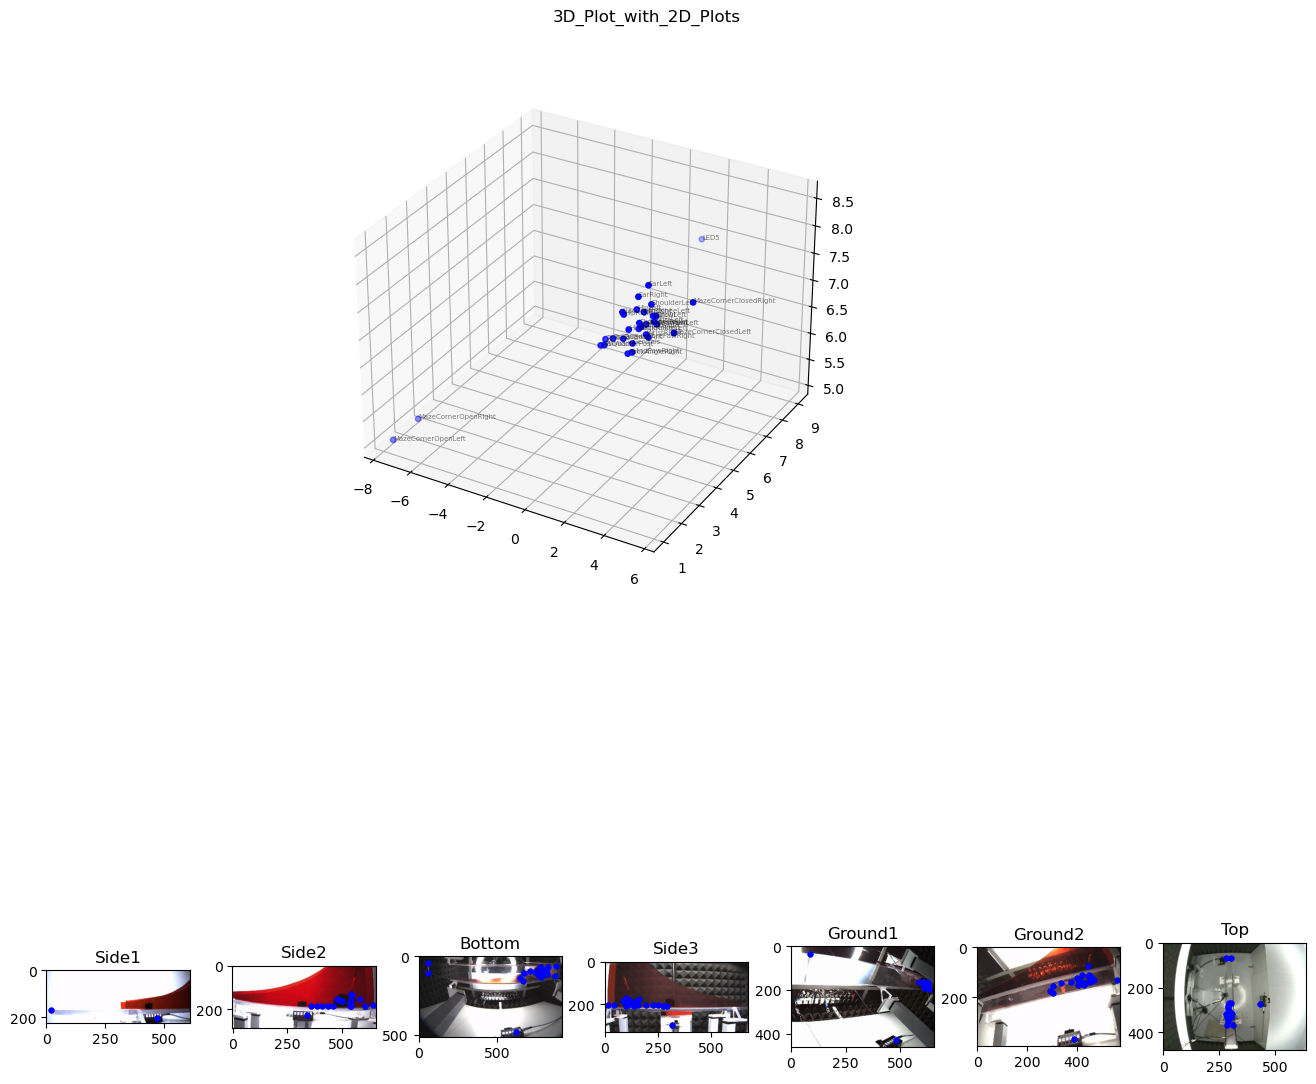

/Users/kobel/let_it_be_3D/core/triangulation_calibration_module.py:578: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[bp + "_" + axis] = all_points_3d_adj[:, bp_num, ax_num]
/Users/kobel/let_it_be_3D/core/triangulation_calibration_module.py:578: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[bp + "_" + axis] = all_points_3d_adj[:, bp_num, ax_num]
/Users/kobel/let_it_be_3D/core/triangulation_calibration_module.py:578: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [10]:
d.triangulate_recordings(test_mode=False)

#### Add metadata to database

In [16]:
# create empty database
import pandas as pd

df = pd.DataFrame(
    {},
    columns=[
        "recording",
        "date",
        "session_id",
        "paradigm",
        "subject_id",
        "group_id",
        "batch",
        "trial_id",
    ],
)
df.to_csv("test.csv", index=False)

In [18]:
# add recording, date, paradigm, subject id
d.add_triangulated_csv_to_database("test.csv")

In [19]:
# add group id, session id, batch, trial id
def add_database_metadata(recording, overwrite=False) -> None:
    old_df = pd.read_csv(database, dtype="str")
    if (
        old_df.loc[
            old_df["recording"] == recording,
            ["session_id", "group_id", "batch", "trial_id"],
        ]
        .isna()
        .any(axis=1)
        .values[0]
        or overwrite
    ):
        subject_id = old_df.loc[old_df["recording"] == recording, "subject_id"].values[
            0
        ]
        recording_date = old_df.loc[old_df["recording"] == recording, "date"].values[0]

        try:
            batch = groups.loc[groups["subject_id"] == subject_id, "batch"].values[0]
        except IndexError:
            raise ValueError(f"Found no group identity for {subject_id}!")
        group = groups.loc[groups["subject_id"] == subject_id, "group_id"].values[0]
        try:
            session = (
                time.loc[time["batch"] == str(batch),]
                .loc[time["date"] == recording_date, "session_id"]
                .values[0]
            )
        except IndexError:
            raise ValueError(f"Found no session identity for {subject_id}!")
        trial_id = (
            time.loc[time["batch"] == batch,]
            .loc[time["date"] == recording_date, "trial_id"]
            .values[0]
        )

        old_df.loc[
            old_df["recording"] == recording,
            ["group_id", "batch", "session_id", "trial_id"],
        ] = (group, batch, session, trial_id)
        old_df.to_csv(database, index=False)
    else:
        print("metadata was already in csv!")


time = pd.read_csv("time.csv", dtype="str")
groups = pd.read_csv("groups.csv", dtype="str")
database = "test.csv"

for recording in pd.read_csv(database, dtype="str")["recording"].values:
    add_database_metadata(recording, overwrite=False)

In [20]:
pd.read_csv("test.csv")

,recording,date,session_id,paradigm,subject_id,group_id,batch,trial_id
0,206_F2-63_220922_OTE,220922,wk1,OTE,206_F2-63,CTRL,2,2


#### create triangulated video
##### (filename, start in s, end in s, output fps, speed)

In [11]:
d.objects["triangulation_recordings_objects"][
    "206_F2-63_220922_OTE"
].create_triangulated_video("test_125fps", 184, 186, 24, 2)

In [ ]:
# rename files in filename_checker rework and retry! DONE
# update filename creation in down- and charucosynchroniser DONE
# update recording_config target_fps DONE
# validate synchronisation on colab! (validate)
# crossvalidation plot DONE (validate)

In [ ]:
# replace positions by calibration_validation everywhere in the code

In [ ]:
# Adaptability:
# no synchronization -> no led pattern, (no target_fps if no framerate change)
# no fisheye lens -> no fisheye information, use_intrinsic_calibration False, no cropping information
# no cropping -> no cropping information
# no framerate change -> no fps, BUT TARGET_FPS (for synchro!)

In [ ]:
# Frame drops?

### The meta .yaml file contains all information stored in d.meta

In [ ]:
d.export_meta_to_yaml(filepath="test_data/test_data.yaml")

In [10]:
# not fully supported at the moment
d.load_meta_from_yaml(filepath="test_data/test_data.yaml")

#### To inspect the files, we recommend https://www.treedoc.org/, which creates a tree-like structured view for .yaml files

## To access calibration_objects directly

In [ ]:
from pathlib import Path
from core.triangulation_calibration_module import (
    Calibration,
    Triangulation_Positions,
    Triangulation_Recordings,
)

In [ ]:
rec_config = Path(
    "test_data/Server_structure/Calibrations/220922/recording_config_220922.yaml"
)
calibration_object = Calibration(
    calibration_directory=rec_config.parent,
    output_directory=rec_config.parent,
    recording_config_filepath=rec_config,
    project_config_filepath="test_data/project_config.yaml",
)

In [ ]:
calibration_object.run_synchronization(test_mode=True)

In [ ]:
calibration_object.run_calibration(verbose=True, test_mode=True)